In [1]:
# ------------Part 1. Scraping data from the SVB Finance Website-----------
import requests
import json
import os

urlAnnual = "https://ir.svb.com/feed/SECFiling.svc/GetEdgarFilingList?LanguageId=1&exchange=CIK&symbol=0000719739&formGroupIdList=1%2C4&filingTypeList=&excludeNoDocuments=true&includeHtmlDocument=false&pageSize=-1&pageNumber=0&tagList=&includeTags=true&year=-1&excludeSelection=1"
header = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"}

# Obtaining response results
responseAnnual = requests.get(urlAnnual, headers=header)
dataAnnual = json.loads(responseAnnual.text) # convert it from html to dictionary 

# looping through the dictionary to fetch the result
pdf_Annuals = []
for doc in dataAnnual["GetEdgarFilingListResult"]:
    for doc2 in doc["DocumentList"]:
        if doc2["DocumentType"] == "CONVPDF":
            pdf_Annuals.append(doc2["Url"])

# print(pdf_Annuals)
# print(len(pdf_Annuals))

In [2]:
# ------------------- Part 2.1 Data Cleaning & Download --------------------
from openpyxl import load_workbook, Workbook

# Cleaning out erroneous files
del pdf_Annuals[19]
del pdf_Annuals[18]
# print(len(pdf_Annuals))

# Download and Rename the PDF file
# rootPath = r"D:\Users\yxluo\PycharmProjects\spider007\\"
rootPath = os.getcwd()

pdfList = []
year = 2022
for pdf_Annual in pdf_Annuals: 
    if year >= 2013:  
        urlfile = requests.get(pdf_Annual)
        fileName = r"\SVB "+ str(year) + ' report.pdf'
        localFile = rootPath + fileName
        pdfList.append(localFile)
        with open(localFile, "wb+") as f:  
            f.write(urlfile.content)   
        year -= 1
        
pdfList.reverse()
# print(pdfList)

# create an excel in the file with relative path
wb = Workbook() # 新建一个workbook
# rootPath = r"D:\Users\yxluo\PycharmProjects\spider007\\"
name = "\\final report"
suffix = '.xlsx' 
newfile = name + suffix
path = rootPath + name + suffix
wb.save(path)


In [3]:
#-------------------- Part 2.2 Scrape Data on PDF ------------------
import re
import PyPDF2 

# Open the existing Excel workbook
workbook = load_workbook(path)
# Add a new worksheet to the workbook
sheet1 = workbook.create_sheet('Deposits')
sheet1.append(["Year", "Deposits"])
# workbook.save(path)
# List of PDF files to process 
pdf_filenames = pdfList 

# Loop through each PDF file in the list
for i, pdf_filename in enumerate(pdf_filenames):
    # Open the PDF file
    with open(pdf_filename, 'rb') as pdf_file:
        # Create a PDF reader object
        pdf_reader = PyPDF2.PdfReader(pdf_file)

        # Loop through each page in the PDF file
        for page_num in range(len(pdf_reader.pages)):
            # Get the page object for the current page
            page = pdf_reader.pages[page_num]
            # Extract the text from the page
            text = page.extract_text()
            # Search for the "deposits" keyword
            if 'total deposits' in text.lower():
                # Use regular expressions to find the first number after the keyword
                match = re.search(r'total deposits\D*(\d[\d,.]*)', text, re.I)
                if match:
                    # Output the found number and add it to the worksheet
                    deposits = float(match.group(1).replace(',', ''))
                    sheet1.append([2013 + i, deposits])
                    print(deposits)
                    break

# Save the Excel workbook
workbook.save(path)

22.5
34.3
39.1
39.0
44.3
49.3
61.8
102.0
189.2
173.1


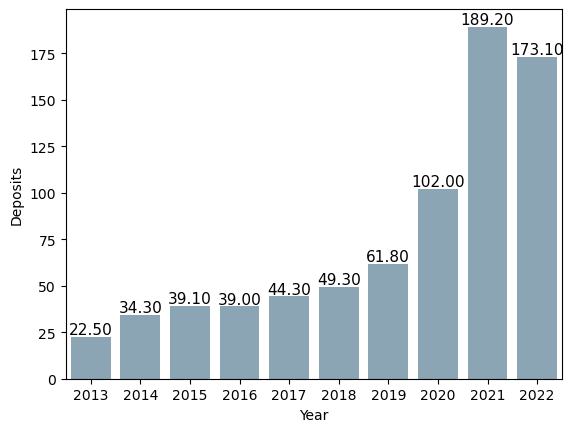

In [4]:
# ------------------------ Part 3. Data Visualization ---------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_bar_chart(file_name, sheet_name, x_col_name, y_col_name):
    
    df = pd.read_excel(file_name, sheet_name = sheet_name)
    
    plt.ylabel('{} (billion)'.format(y_col_name))
    
    color_palette = sns.color_palette("Blues", n_colors=1, desat=0.5)
    
    ax = sns.barplot(x=x_col_name, y=y_col_name, data=df, color=color_palette[0])
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.show()

    
plot_bar_chart(path, 'Deposits', 'Year', 'Deposits')

In [5]:
# Special part for data visualization
def plot_line_chart(file_name, sheet_name, x_col_name, y_col_name):
    
    df = pd.read_excel(file_name, sheet_name=sheet_name)

    df[x_col_name] = pd.to_datetime(df[x_col_name])
  
    sns.set(rc={'figure.figsize':(19,5)})
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    
    color_palette = sns.color_palette("Blues", n_colors=1, desat=0.5)
    
    ax = sns.lineplot(x=x_col_name, y=y_col_name, data=df, color=color_palette[0], marker='')

    
    ax.set_xlabel(x_col_name)
    ax.set_ylabel('{} (%)'.format(y_col_name))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xlim(pd.to_datetime('1985-03-01'), pd.to_datetime('2023-03-01'))
    plt.xticks(rotation='vertical')
    
    plt.show()
    
def plot_bar_chart_1(df, x_col, y_col):
    
    df[x_col] = df[x_col].astype(str)
    
    df.set_index(x_col, inplace=True)

    fig, ax = plt.subplots(figsize=(19, 4))

    df.plot(kind='bar', ax=ax, width=0.4, color='#8696a7')
    
    ax.set_xticklabels(df.index, rotation=90)
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.show()

def plot_clustered_bar_chart(df, x_col, y1_col, y2_col):
    
    df[x_col] = df[x_col].astype(str)

    
    df.set_index(x_col, inplace=True)
    
    
    fig, ax = plt.subplots(figsize=(19, 4))

    df.plot(kind='bar', ax=ax, width=0.4, color=['#8696a7', '#b5c4b1'])
    
    ax.set_xticklabels(df.index, rotation=90)
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    ax.legend(labels=[y1_col, y2_col], loc='upper left')
    
    plt.show()


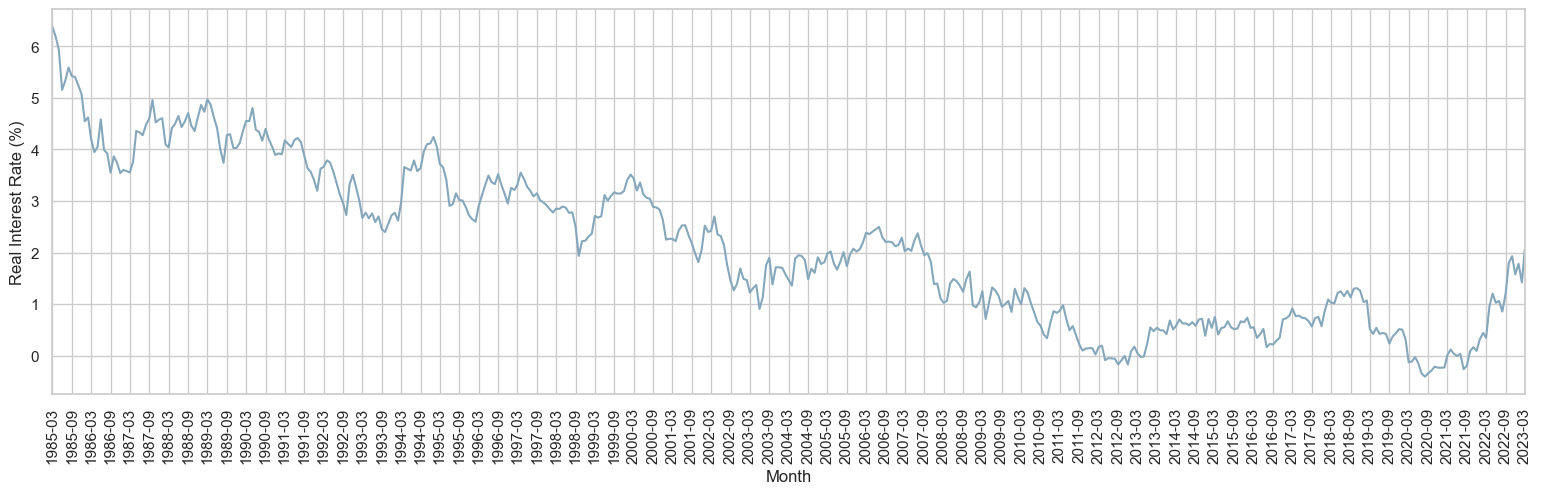

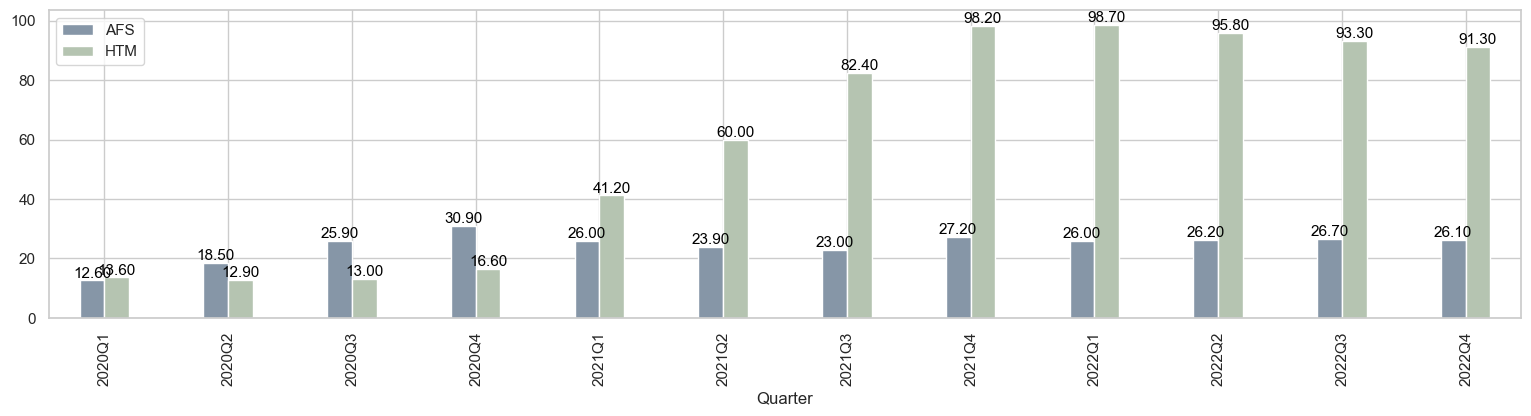

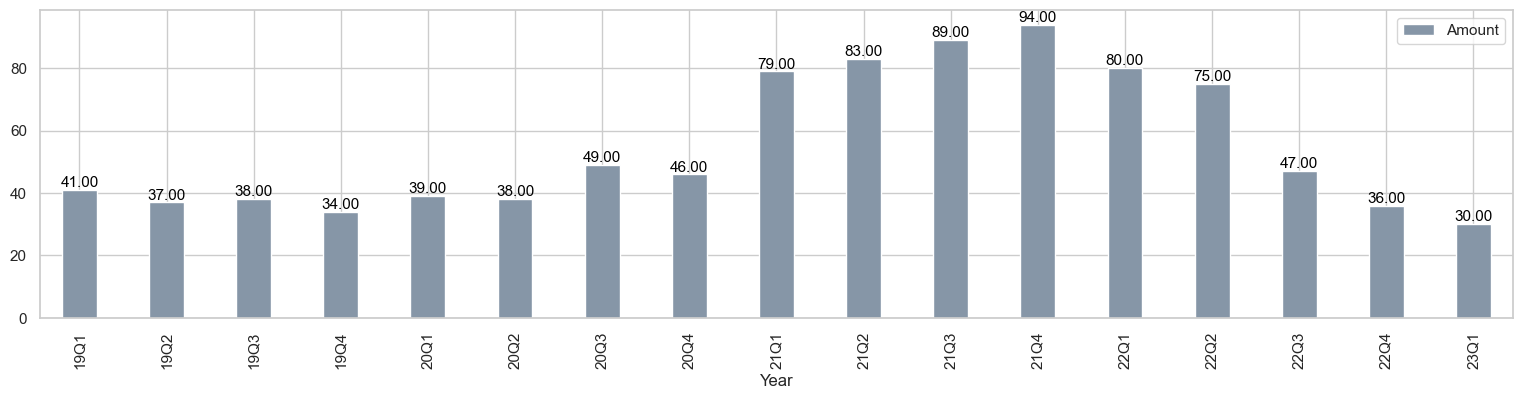

In [7]:
root_path = os.getcwd()
excel_path = os.path.join(root_path, "final report-visualization.xlsx")
# print(excel_path)
# relative path

plot_line_chart(excel_path, 'real interest rate', 'Month', 'Real Interest Rate')


df = pd.read_excel(excel_path, sheet_name='AFS & HTM')
plot_clustered_bar_chart(df, 'Quarter', 'AFS', 'HTM')

df = pd.read_excel(excel_path, sheet_name='VC-backed investment activity')
plot_bar_chart_1(df, 'Year', 'Amount')
